## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Summary:

In [5]:
# from IPython.display import Image
# Image("process_2.png")

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [6]:
spotify_df = pd.read_csv('data_o.csv')

In [7]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [8]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [9]:
data_w_genre = pd.read_csv('data_by_artist_o.csv')
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [10]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

This checks whether or not `genres` is actually in a list format:

In [11]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [12]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [13]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [14]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [15]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [16]:
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [17]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

This looks good but did this work for every artist string format. Let's double check

In [18]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[]
234,0.902,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.708,194533,0.361,0,1xEEYhWxT4WhDQdxfPCT8D,0.883000,0,0.103,-11.764,0,Snake Rag,20,1923,0.0441,105.695,[]
238,0.554,1923,0.996,"[""King Oliver's Creole Jazz Band""]",0.546,170827,0.189,0,3rauXVLOOM5BlxWqUcDpkg,0.908000,0,0.339,-15.984,1,Chimes Blues,13,1923,0.0581,80.318,[]
244,0.319,1923,0.995,"[""Clarence Williams' Blue Five""]",0.520,197493,0.153,0,1UdqHVRFYMZKU2Q7xkLtYc,0.131000,0,0.353,-14.042,1,Pickin' On Your Baby,11,1923,0.0440,102.937,[]
249,0.753,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.359,187227,0.357,0,5SvyP1ZeJX1jA7AOZD08NA,0.819000,3,0.290,-11.810,1,Tears,10,1923,0.0511,205.053,[]


So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [19]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [20]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [21]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [22]:
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
38319,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,8,0.102,-3.675,1,Adore You,77,2019-12-06,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [23]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [24]:
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


Now I can explode this column and merge as I planned to in `Step 2`

In [25]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [26]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [27]:
artists_exploded_enriched_nonnull[ artists_exploded_enriched_nonnull['id'] == '6KuQTIu1KoTTkLXKrwlLPV' ]

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd


In [28]:
spotify_df.head(100)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
164470,0.1770,1989,0.56800,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야
150072,0.3520,1992,0.38100,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART
159177,0.4580,1963,0.98700,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調
144483,0.7960,1963,0.85200,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公
144488,0.7040,1963,0.77100,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起
159169,0.7400,1963,0.72500,['黃國隆'],0.646,183946,0.2040,0,3tIPRVHChwXaJWUhhXeEwr,0.000003,2,0.2370,-22.098,0,小妹呀喂,23,1963-05-28,0.0389,113.046,[黃國隆],[],[黃國隆],黃國隆小妹呀喂
159159,0.8190,1963,0.69100,['黃國隆'],0.471,153786,0.1510,0,2bZZ8pKWvQdd0CV9CcbfKM,0.000000,5,0.0994,-21.054,1,卜卦調,23,1963-05-28,0.0460,147.327,[黃國隆],[],[黃國隆],黃國隆卜卦調
144503,0.9580,1963,0.72000,['黃國隆'],0.816,147373,0.1870,0,7jSt9XJHRynGrrcnnIpOcf,0.000000,9,0.1150,-20.530,0,丟丟銅仔,23,1963-05-28,0.0930,124.617,[黃國隆],[],[黃國隆],黃國隆丟丟銅仔
69206,0.2430,1990,0.54100,['黃品源'],0.578,293840,0.3340,0,1M97kKsHd1mw2rj4WCH2TA,0.000006,9,0.0675,-11.974,0,你怎麼捨得我難過,48,1990-06-30,0.0267,135.934,[黃品源],[],[黃品源],黃品源你怎麼捨得我難過
85588,0.2780,1986,0.88400,['鳳飛飛'],0.358,259387,0.2080,0,5cbbtFwm09MwwicU9SDHJA,0.000002,10,0.1500,-9.524,1,掌聲響起,43,1986-09-30,0.0339,131.261,[鳳飛飛],[],[鳳飛飛],鳳飛飛掌聲響起


Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [29]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [30]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [31]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[rock, dance_rock, permanent_wave, new_wave_po..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[pop_rap, conscious_hip_hop, minnesota_hip_hop..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_bollywood, ghazal, classic_pakistani_..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[ragtime, piano_blues, stride, boogie-woogie]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [32]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

In [33]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop]
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]"
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調,[]
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[]
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起,[]


## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [34]:
spotify_df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
156602,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,11,0.123,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN
156603,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,0,0.131,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
156604,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,1,0.222,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
156605,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,9,0.139,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
156606,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,4,0.101,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [35]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [36]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [37]:
float_cols

array(['valence', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype=object)

In [38]:
ohe_cols = 'popularity'

In [39]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [40]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [41]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [42]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起,[],4


In [43]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [44]:
# from IPython.display import Image
# Image("tfidf_4.png")

In [45]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [46]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [47]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   genre|acid_rock  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              0.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_pop  genre|acoustic_punk  \
0                   0.0                 0.0                  0.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  0.0   
3                   0.0                 0.0                  0.0   
4                   0.0                 0.0                  0.0   

   genre|acoustic_rock  genre|action_rock  genre|adoracion  \
0                  0.0                0.0              0.0   
1                  0.0                0.0              0.0   
2                  0.0                0.0              0.0   
3                  0.0                0.0              0.0   
4                  0.0                0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|afghan_traditional  genre|african  genre|african_percussion  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   
3                       0.0            0.0                       0.0   
4                       0.0            0.0                       0.0   

   genre|african_reggae  genre|african_rock  genre|afro  genre|afro_dancehall  \
0                   0.0                 0.0         0.0                   0.0   
1                   0.0                 0.0         0.0                   0.0   
2                   0.0                 0.0         0.0                   0.0   
3                   0.0                 0.0         0.0                   0.0   
4                   0.0                 0.0         0.0                   0.0   

   genre|afro_house  genre|afro_psych  genre|afro_soul  genre|afrobeat  \
0               0.0               0.0              0.0             0.0   
1               0.0               0.0              0.0             0.0   
2   

In [48]:
spotify_df.shape

(156607, 25)

In [49]:
spotify_df.drop('consolidates_genre_lists',axis=1).to_csv('spotify_df.csv',index=False)

In [50]:
complete_feature_set.to_csv('complete_feature_set.csv',index=False)

In [58]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起,[],4


## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [49]:
#Artist image

# name = 'pranjli'
# results = sp.search(q='artist:' + 'pranjli', type='artist')
# items = results['artists']['items']
# if len(items) > 0:
#     artist = items[0]
#     print(artist['name'], artist['images'][0]['url'])
    
    
#Songs for that year

# artist_name = []
# track_name = []
# popularity = []
# track_id = []
# for i in range(0,950,25):
#     track_results = sp.search(q='year:2019', type='track', limit=50,offset=i)
#     for i, t in enumerate(track_results['tracks']['items']):
#         artist_name.append(t['artists'][0]['name'])
#         track_name.append(t['name'])
#         track_id.append(t['id'])
#         popularity.append(t['popularity'])

In [50]:
#client id and secret for my application
client_id = '79ca288b68884e198c53146b51adfa1e'
client_secret= '63242b064ebb4e379bfca173dd482e79'

In [51]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s 31stmbnj67vlwdq5w24dt76ti7wm" % (sys.argv[0],))
    sys.exit()

In [52]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [53]:
token = util.prompt_for_user_token(username=username,scope=scope,client_id=client_id,client_secret=client_secret,redirect_uri='http://localhost:8881/')

In [54]:
sp = spotipy.Spotify(auth=token)

In [55]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [56]:
id_name

{'Light': '4n09mCMMggc3iVzNDMe5H4',
 'Energy Boosters': '2ABFsfdI25HFRRyYf9mtqe',
 'Little bit of Everything': '2N4pAH56rECI7dvLoT9OLo'}

In [57]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [58]:
playlist_eve = create_necessary_outputs('Energy Boosters', id_name,spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [59]:
playlist_eve

,artist,name,id,url,date_added
15,League of Legends,Legends Never Die - (Remix),66YtIqT0kN4958EXnCnAmE,https://i.scdn.co/image/ab67616d00001e021578de...,2021-04-27 08:09:52+00:00
14,NEFFEX,Grateful,1e6aAbWR0MXCNcr4yQovNr,https://i.scdn.co/image/ab67616d00001e0291b467...,2021-04-27 06:37:19+00:00
12,Linkin Park,LOST IN THE ECHO,2oNYsdCasRRlz1shXFAz7D,https://i.scdn.co/image/ab67616d00001e02987fb4...,2021-04-27 06:36:56+00:00
11,Linkin Park,Numb,2nLtzopw4rPReszdYBJU6h,https://i.scdn.co/image/ab67616d00001e02b4ad7e...,2021-04-27 06:36:45+00:00
8,League of Legends,RISE,69Sy7207dnixZ6w7RSV9Kb,https://i.scdn.co/image/ab67616d00001e02304ae5...,2021-04-27 06:34:43+00:00
7,The Score,Unstoppable,6rrKbzJGGDlSZgLphopS49,https://i.scdn.co/image/ab67616d00001e02c469e7...,2021-04-27 06:34:38+00:00
6,League of Legends,Legends Never Die,1FpVJ7HpZInE2GvhVE2TwT,https://i.scdn.co/image/ab67616d00001e02cb5ec4...,2021-04-27 06:34:26+00:00
3,NEFFEX,Fight Back,6KigD0mlF4VGDYiSEzAyYw,https://i.scdn.co/image/ab67616d00001e02bd9e94...,2021-04-27 04:44:53+00:00
2,Idina Menzel,"Let It Go - From ""Frozen""/Soundtrack Version",0qcr5FMsEO85NAQjrlDRKo,https://i.scdn.co/image/ab67616d00001e024b1899...,2021-04-27 04:44:36+00:00
1,Linkin Park,From the Inside,60IkVf7UfQXmt5CwkpcX8a,https://i.scdn.co/image/ab67616d00001e02b4ad7e...,2021-04-27 04:43:47+00:00


In [60]:
sp.playlist(id_name['Energy Boosters'])['tracks']['items']

[{'added_at': '2021-04-27T04:43:22Z',
  'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/31stmbnj67vlwdq5w24dt76ti7wm'},
   'href': 'https://api.spotify.com/v1/users/31stmbnj67vlwdq5w24dt76ti7wm',
   'id': '31stmbnj67vlwdq5w24dt76ti7wm',
   'type': 'user',
   'uri': 'spotify:user:31stmbnj67vlwdq5w24dt76ti7wm'},
  'is_local': False,
  'primary_color': None,
  'track': {'album': {'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53XhwfbYqKCa1cC15pYq2q'},
      'href': 'https://api.spotify.com/v1/artists/53XhwfbYqKCa1cC15pYq2q',
      'id': '53XhwfbYqKCa1cC15pYq2q',
      'name': 'Imagine Dragons',
      'type': 'artist',
      'uri': 'spotify:artist:53XhwfbYqKCa1cC15pYq2q'}],
    'available_markets': ['AD',
     'AE',
     'AG',
     'AL',
     'AM',
     'AO',
     'AR',
     'AT',
     'AU',
     'AZ',
     'BA',
     'BB',
     'BD',
     'BE',
     'BF',
     'BG',
     'BH',
     'BI',
     'BJ',
     'BN',


In [81]:
# list(playlist_eve['id'])

In [82]:
id_list = ['66YtIqT0kN4958EXnCnAmE','1e6aAbWR0MXCNcr4yQovNr','2oNYsdCasRRlz1shXFAz7D','2nLtzopw4rPReszdYBJU6h','69Sy7207dnixZ6w7RSV9Kb','6rrKbzJGGDlSZgLphopS49','1FpVJ7HpZInE2GvhVE2TwT','6KigD0mlF4VGDYiSEzAyYw','0qcr5FMsEO85NAQjrlDRKo','60IkVf7UfQXmt5CwkpcX8a','0pqnGHJpmpxLKifKRmU6WP']
default_date = pd.to_datetime('2021-04-27 08:09:52+00:00')
defailt_url = 'https://i.scdn.co/image/ab67616d00001e025675e83f707f1d7271e5cf8a'

In [83]:
def createPlaylist(id_list):
    idDF = pd.DataFrame({'artist':[],'name':[],'id':[],'url':[],'date_added':[]})
    for id in id_list:
        artistName = spotify_df[spotify_df['id'] == id]['artists_upd_v1'].iloc[0][0]
        songName = spotify_df[spotify_df['id'] == id]['name'].values[0]
        newRow = {'artist':artistName,'name':songName,'id':id,'url':defailt_url,'date_added':default_date}
        idDF = idDF.append(newRow,ignore_index=True)
    return idDF

In [85]:
playlist_eve = createPlaylist(id_list)

In [86]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [87]:
playlist_eve

,artist,name,id,url,date_added
0,League of Legends,Legends Never Die - (Remix),66YtIqT0kN4958EXnCnAmE,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
1,NEFFEX,Grateful,1e6aAbWR0MXCNcr4yQovNr,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
2,Linkin Park,LOST IN THE ECHO,2oNYsdCasRRlz1shXFAz7D,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
3,Linkin Park,Numb,2nLtzopw4rPReszdYBJU6h,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
4,League of Legends,RISE,69Sy7207dnixZ6w7RSV9Kb,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
5,The Score,Unstoppable,6rrKbzJGGDlSZgLphopS49,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
6,League of Legends,Legends Never Die,1FpVJ7HpZInE2GvhVE2TwT,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
7,NEFFEX,Fight Back,6KigD0mlF4VGDYiSEzAyYw,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
8,Idina Menzel,"Let It Go - From ""Frozen""/Soundtrack Version",0qcr5FMsEO85NAQjrlDRKo,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00
9,Linkin Park,From the Inside,60IkVf7UfQXmt5CwkpcX8a,https://i.scdn.co/image/ab67616d00001e025675e8...,2021-04-27 08:09:52+00:00


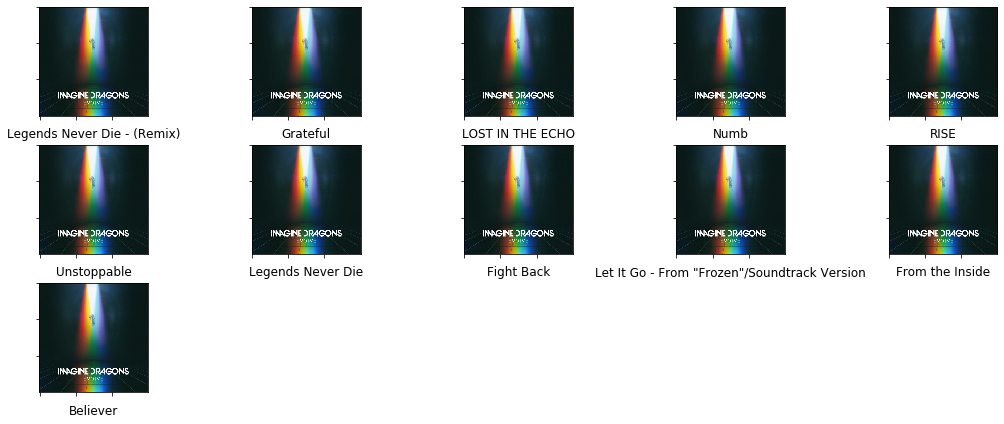

In [88]:
visualize_songs(playlist_eve)

## 4. Create Playlist Vector

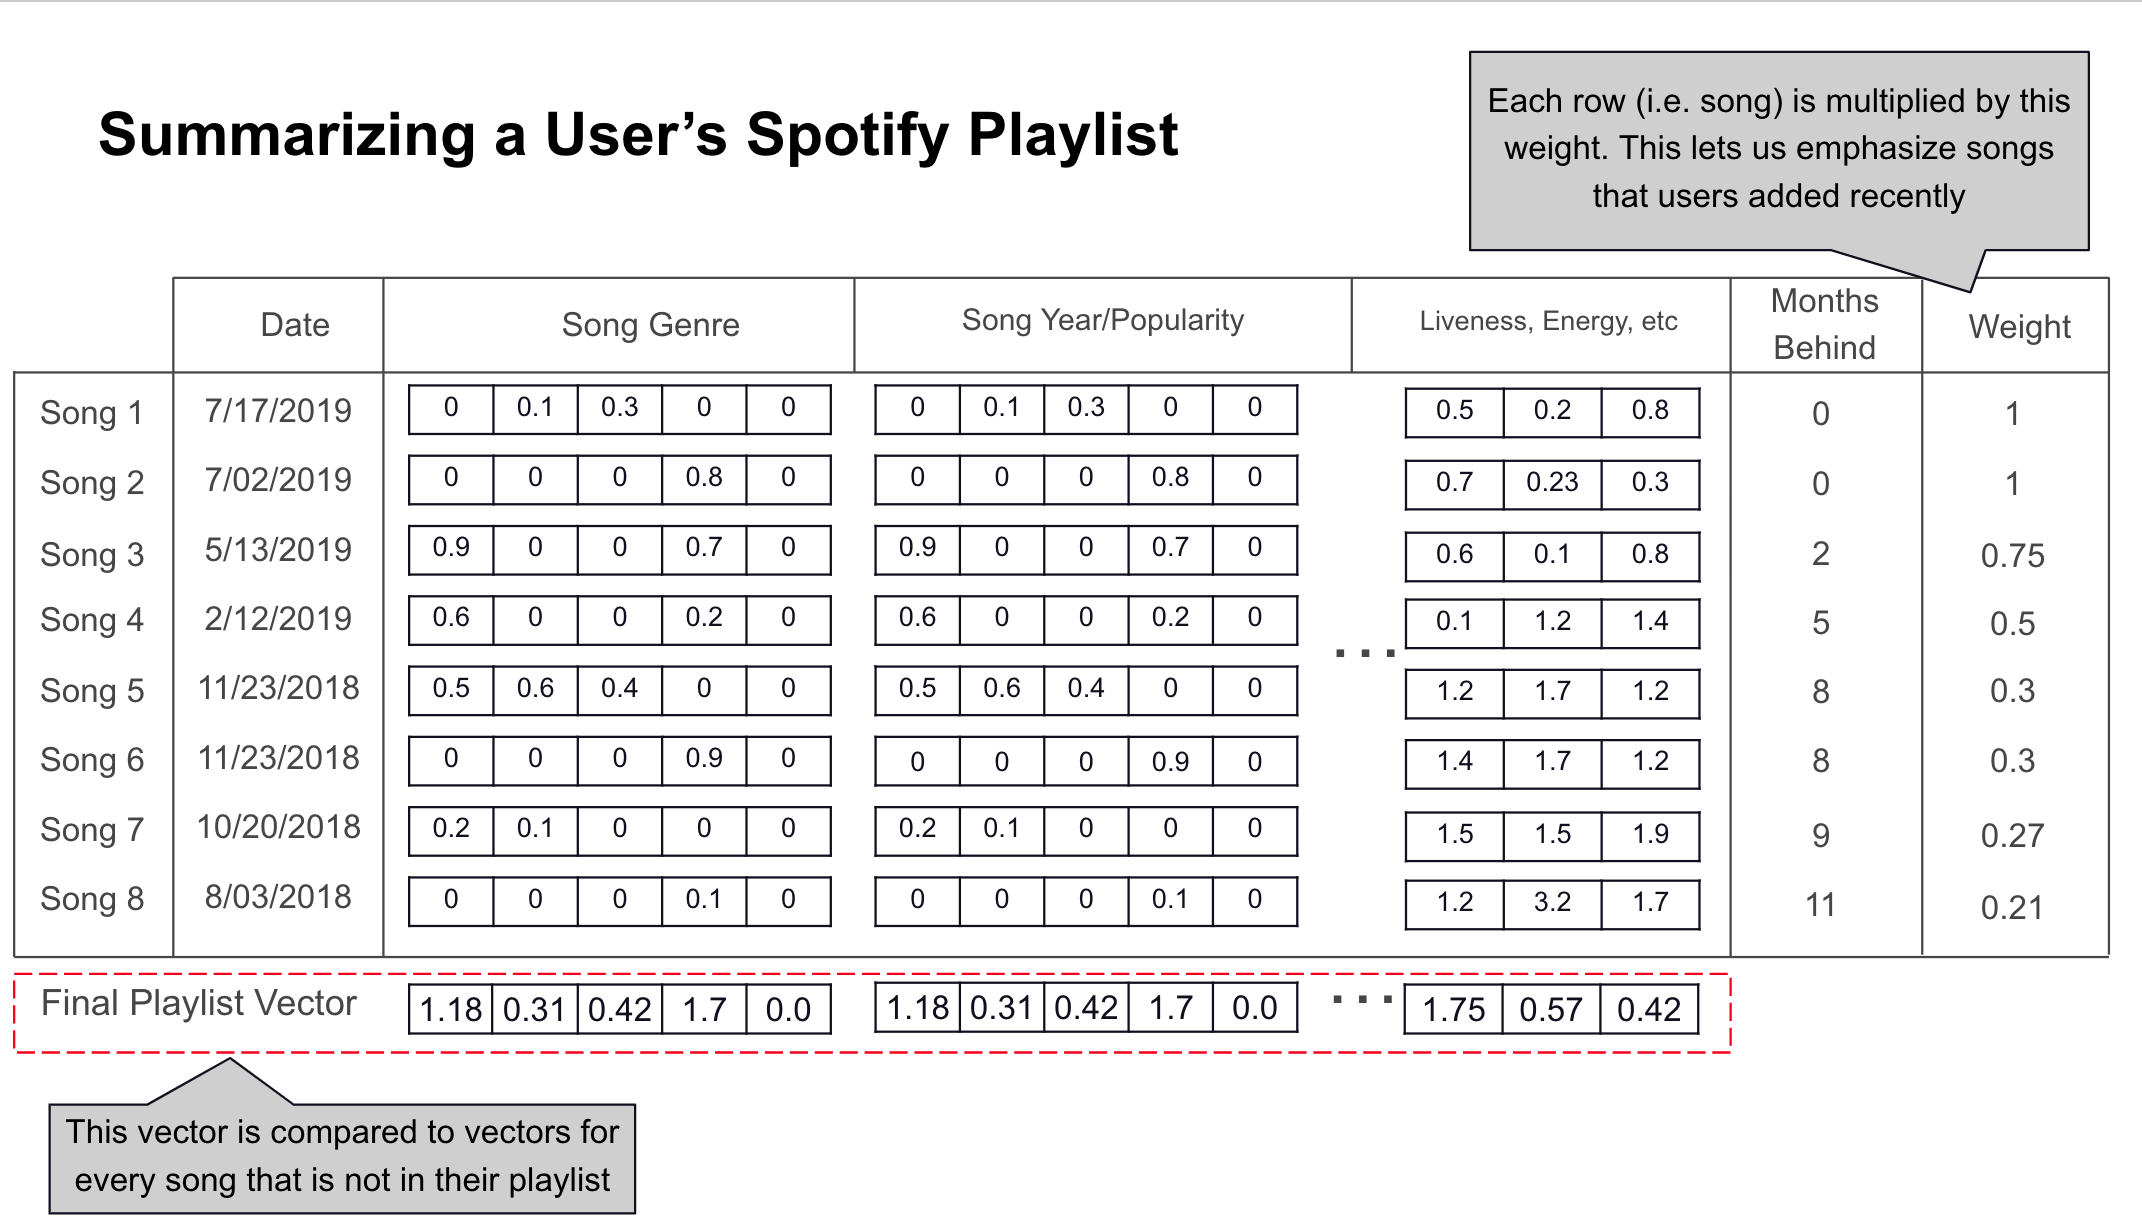

In [89]:
from IPython.display import Image
Image("summarization_2.png")

In [90]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [91]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_eve, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [92]:
complete_feature_set_playlist_vector_EDM.shape

(3070,)

## 5. Generate Recommendations

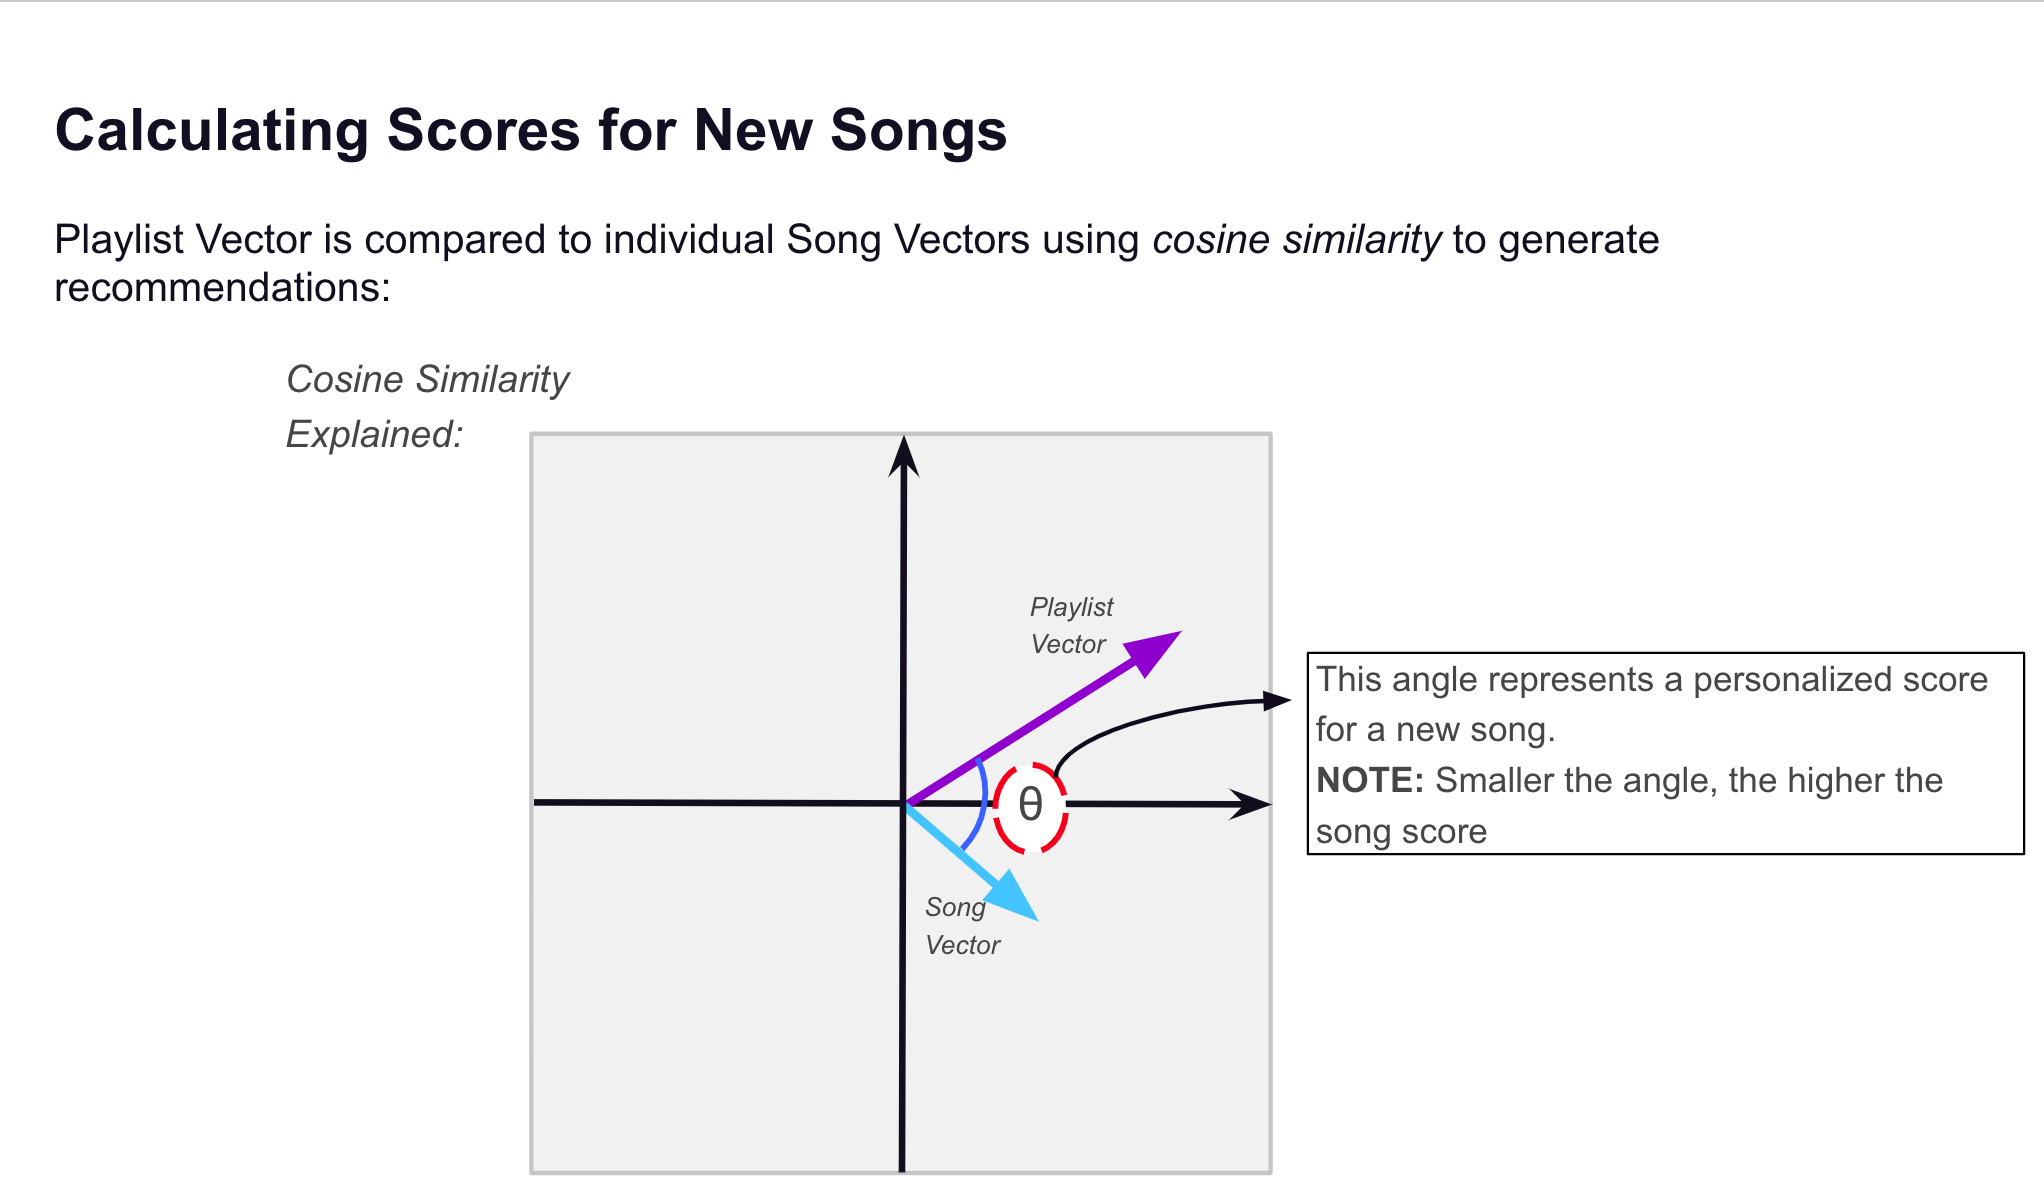

In [93]:
from IPython.display import Image
Image("cosine_sim_2.png")

In [94]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(10)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [95]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [96]:
edm_top40

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
102266,0.644,2018,0.000198,['Godsmack'],0.390,177048,0.910,0,6w7ily4cFWEPO0XWFQYeUO,0.000000,5,0.1560,-3.268,0,Bulletproof,65,2018-04-27,0.1330,162.253,[Godsmack],[],[Godsmack],GodsmackBulletproof,"[nu_metal, rap_metal, alternative_metal, post-...",13,0.677668,https://i.scdn.co/image/ab67616d00001e02acdd60...
73782,0.170,2017,0.904000,['Linkin Park'],0.593,255067,0.200,0,3xXBsjrbG1xQIm1xv1cKOt,0.000000,8,0.0897,-11.063,1,One More Light,73,2017-05-19,0.0311,83.966,[Linkin Park],[],[Linkin Park],Linkin ParkOne More Light,"[nu_metal, rap_metal, alternative_metal, post-...",14,0.669319,https://i.scdn.co/image/ab67616d00001e02145e1c...
102225,0.401,2018,0.000236,['Godsmack'],0.440,172826,0.916,0,1Si7crvw1M6Kgz9XiAtMiJ,0.000019,4,0.0897,-4.222,0,When Legends Rise,62,2018-04-27,0.2660,124.099,[Godsmack],[],[Godsmack],GodsmackWhen Legends Rise,"[nu_metal, rap_metal, alternative_metal, post-...",12,0.664530,https://i.scdn.co/image/ab67616d00001e02acdd60...
102231,0.219,2018,0.056800,['Godsmack'],0.252,231118,0.764,0,60SjEdocmsrAk4hQUu7qZi,0.000002,11,0.1220,-4.153,0,Under Your Scars,62,2018-04-27,0.0402,165.358,[Godsmack],[],[Godsmack],GodsmackUnder Your Scars,"[nu_metal, rap_metal, alternative_metal, post-...",12,0.653399,https://i.scdn.co/image/ab67616d00001e02acdd60...
73814,0.594,2003,0.111000,['Linkin Park'],0.554,162600,0.978,0,4Yf5bqU3NK4kNOypcrLYwU,0.000000,4,0.0731,-3.554,1,Faint,70,2003-03-24,0.1310,135.095,[Linkin Park],[],[Linkin Park],Linkin ParkFaint,"[nu_metal, rap_metal, alternative_metal, post-...",14,0.649005,https://i.scdn.co/image/ab67616d00001e02b4ad7e...
73801,0.878,2003,0.062900,['Linkin Park'],0.740,164213,0.959,0,5VYbLzAplnqPaGNpcf8qhZ,0.000000,9,0.0444,-3.692,1,Hit the Floor,52,2003-03-24,0.1930,150.007,[Linkin Park],[],[Linkin Park],Linkin ParkHit the Floor,"[nu_metal, rap_metal, alternative_metal, post-...",10,0.648296,https://i.scdn.co/image/ab67616d00001e02ce4b72...
73791,0.723,2003,0.007770,['Linkin Park'],0.535,175373,0.951,0,3BmjRmFTESgWZLPSVGp8aG,0.000000,3,0.0669,-3.324,0,Lying from You,59,2003-03-24,0.1800,160.102,[Linkin Park],[],[Linkin Park],Linkin ParkLying from You,"[nu_metal, rap_metal, alternative_metal, post-...",11,0.645305,https://i.scdn.co/image/ab67616d00001e02ce4b72...
73818,0.679,2003,0.001530,['Linkin Park'],0.488,187933,0.995,0,27gUeiai56GKF6TxvmPJut,0.000000,1,0.9110,-3.096,0,Don't Stay,56,2003-03-24,0.1080,90.058,[Linkin Park],[],[Linkin Park],Linkin ParkDon't Stay,"[nu_metal, rap_metal, alternative_metal, post-...",11,0.641301,https://i.scdn.co/image/ab67616d00001e02ce4b72...
73790,0.650,2003,0.008530,['Linkin Park'],0.396,184493,0.974,0,6mqovuFmVj2GFvtqI1Oae5,0.000000,6,0.9680,-3.708,1,Lying from You - Live LP Underground Tour 2003,40,2003-03-24,0.1420,160.057,[Linkin Park],[],[Linkin Park],Linkin ParkLying from You - Live LP Undergroun...,"[nu_metal, rap_metal, alternative_metal, post-...",8,0.640311,https://i.scdn.co/image/ab67616d00001e02ce4b72...
30645,0.427,2017,0.002640,['Stone Sour'],0.481,256533,0.945,0,5jsDxDkJ1PqyYUWhDMr86B,0.000000,1,0.1350,-5.468,1,Song #3,64,2017-06-30,0.0813,157.059,[Stone Sour],[],[Stone Sour],Stone SourSong #3,"[nu_metal, rock, alternative_metal, post-grunge]",12,0.639151,https://i.scdn.co/image/ab67616d00001e0249ca1d...


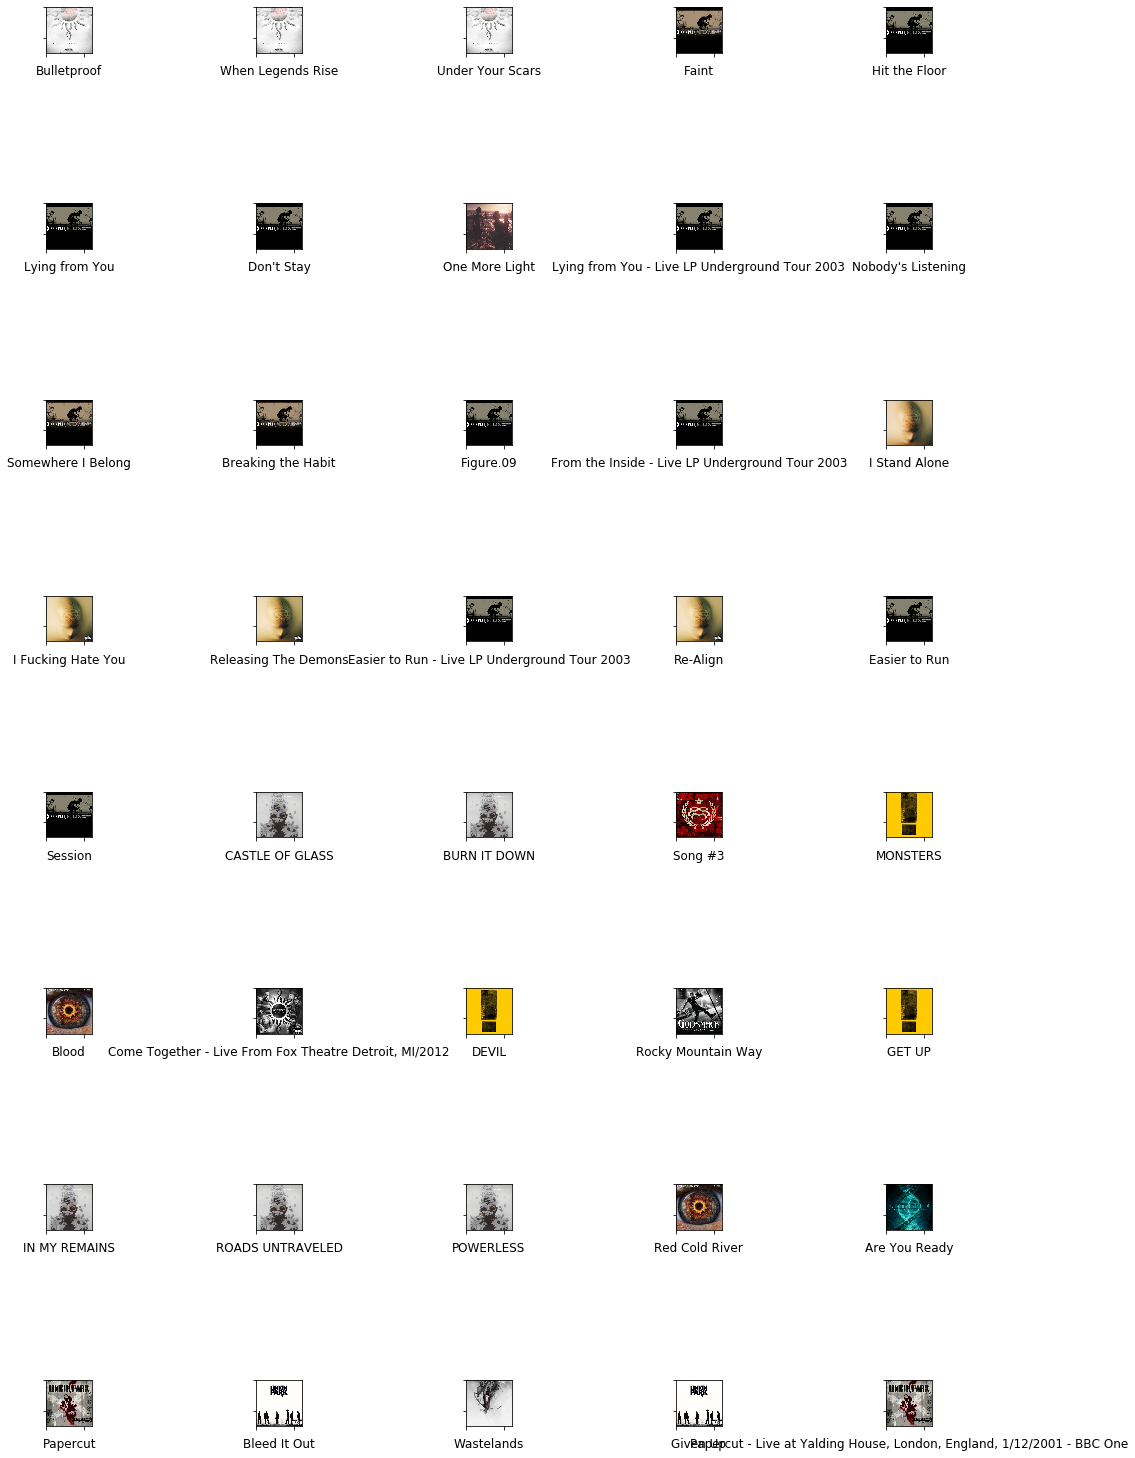

In [111]:
visualize_songs(edm_top40)

In [ ]:
chill_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill)

In [75]:
spotify_df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'artists_upd_v1', 'artists_upd_v2',
       'artists_upd', 'artists_song', 'consolidates_genre_lists',
       'popularity_red'],
      dtype='object')